<a href="https://colab.research.google.com/github/rokmr/Image-Processing/blob/main/Image__Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation Introduction

There are mainly two method of image segmentation


1.   Bottom Up - from pixel to segmetation (low level feaatures like colour is used)
2.   Top Down

Currently Segmentation means as SEMANTIC SEGMENTATION (i.e., thought as dense classification)

Basic - No prior knowledege of the image is known (NCUT Method)

Advanced - Some prior knowledge of the image is known e.g. medical image like heart. (FCN)

Some Classical methods:


*   k means Clustering
*   Histogram 

#Graph Basics



G = (V, E), where V-Node, E-Edge

W_ij = Similarity(Pixel_i, Pixel_j)

Define wimilarity matrix W dim (M*N, M*N)

Define a node: di = ∑ⱼ Wᵢⱼ ----- i.e., Sum of all iᵗʰ row element

Define Degree Matrix : diag matrix with diagonal matrix element as d\_i

# Normalized Cut (NCUT Algorithm)

Cut(A, B) = ∑ᵢ,ⱼ Wᵢⱼ,   where i 𝝐 A, j 𝝐 B

We want to choose that partition that gives minimum partition i.e., minimum Cut(A, B) 

Issue : It will try to partion out the individual pixel

Remedy : NCUT

NCut =  Cut(A, B)/Ass(A, V) + Cut(A, B)/Ass(B, V)

NAsso =  Cut(A, A)/Ass(A, V) + Cut(B, B)/Ass(B, V)

NCut = 2 - NAsso(A, B)

---

x = ()ₘₙ   with xᵢ𝛜 {1,-1} 

xᵢ = {1 if xᵢ 𝛜 A , -1 if xᵢ 𝛜 B


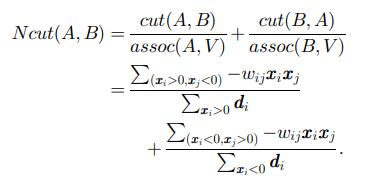

y = (1+x) - b(1-x)

when  
     
     x = 1 then y = 2 
     x = -1 then y = 2b

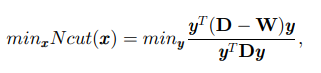 
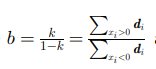
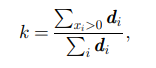

D - W : Laplacian Matrix, it is PSD Matrix 

Solve for y using Lagarange Multiplier

L = yᵀ(D-W)y - λ(yᵀDy - 1)

(D-W)y =  λDy 

yᵀD1 = 0


The Second smallest eigen vector is real valued solution to this problem
Get Second smallest eigen vetor of D - W and reshape i:t as image dimension. 

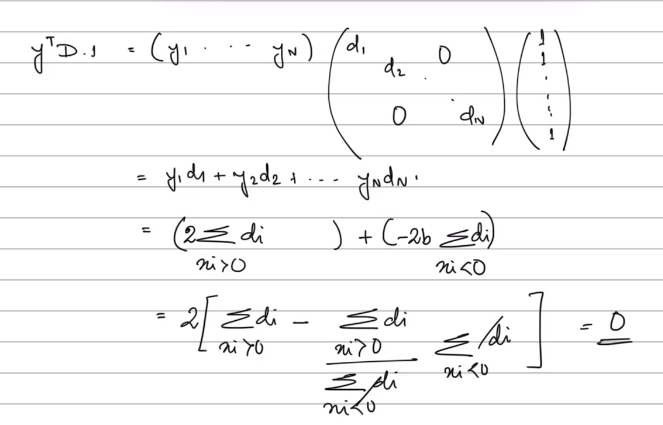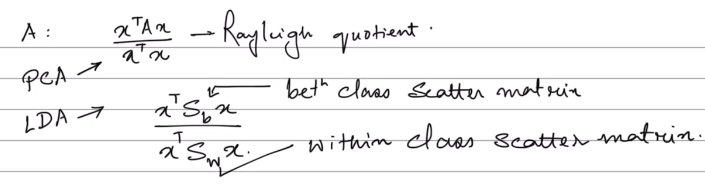

# Code Part

In [615]:
# Importing necessary library
import skimage, skimage.color, skimage.transform, skimage.io
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as alg
from scipy.sparse.linalg import eigsh
import cv2

## Data Preparation

In [616]:
# Connecting Goofle drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [618]:
from pathlib import Path
import zipfile

# Creating a data directory
data_path = Path("data/")
data = Path('/content/drive/Shareddrives/Colab/AIP_Assignment/A2/test_images.zip')

if data_path.is_dir():                         #Checking if dir is already present
    print("Directory is already present!")
else:                                          
  data_path.mkdir(parents=True, exist_ok=True) # Creating New one
  print(f"{data_path} directory is made.")

  with zipfile.ZipFile(data, "r") as zip_ref:  #Extacting the zip file
    zip_ref.extractall(data_path)

Directory is already present!


## Class for segmentaion using brightness of image

In [624]:
class segmentation_brightness:
  def __init__(self, image, name, resizeFactor):
    # Convering image to grayscale afd downscaleing for easy computation
    self.grayscale = skimage.transform.rescale(skimage.color.rgb2gray(image), resizeFactor)
    self.m, self.n = self.grayscale.shape
    self.im = self.grayscale.flatten()
    self.i, self.j = np.indices((self.im.shape[0], self.im.shape[0]))
    self.name = name
        
  def __str__(self):
    return f"Image Segmentation using image brightness."
  
  @property
  def W1(self): 
    # Calcualting W matrix for segmentaion using brightness
    return np.exp(-(self.im[self.i]-self.im[self.j])**2/2)
    
  
  def segment(self,W):
    # dis = np.exp(-(self.i-self.j)**2/2)   # distance consideration
    # W = np.multiply(W, dis<10)            # if distance is less than 10 then only considered
    d_element = np.sum(W, axis=1)       
    D = np.diag(d_element)
    A=D-W
    B=D                                           # Defining B for faster computation done by eigsh
    _, v0 = eigsh(A, k=2, M=B, which='SA')        # Computing 2 smallest eigen values and vetor
    output = v0[:,1].reshape(self.m, self.n)    # reshaping the eigen 2nd smallest eigen
    return output

  @staticmethod
  def plotter(image, name):  
    plt.imshow(image, cmap= 'gray')
    plt.title(name)
    plt.axis(False)
  
    
  @property
  def bright(self):
    return self.segment(self.W1)>0             

## Class for segmentaion using color of image

In [628]:
class segmentation_color(segmentation_brightness):

  def __init__(self, image, name, resizeFactor):
    # downscaleing image for easy computation
    self.image = image
    self.name = name
    self.m, self.n = int(image.shape[0] * resizeFactor), int(image.shape[1]* resizeFactor)
    self.resized_img = cv2.resize(image, (self.n, self.m), interpolation = cv2.INTER_CUBIC)
    self.i, self.j = np.indices((self.m*self.n, self.m*self.n))

  @property
  def W2(self):
    # Calcualting W: similarity matrix for segmentaion using color
    R, B, G = cv2.split(self.resized_img)                     # Extracting all 3 channel at once
    p = (R.flatten()*256**2+ G.flatten()*256+ B.flatten()).astype(int)   # Making RGB-> HEX -> Decimal map
    W = np.zeros([p.shape[0], p.shape[0]]).astype(float)
    
    # computing element of W
    for i in range(p.shape[0]):
        for j in range(i+1):
            W[i, j] =abs(p[i]- p[j])
            W[j, i] = W[i, j]

    W= (16**6-1) - W                  
    return W

  @property
  def color(self):
    return self.segment(self.W2)>0
    

## Calculaiton and Output 

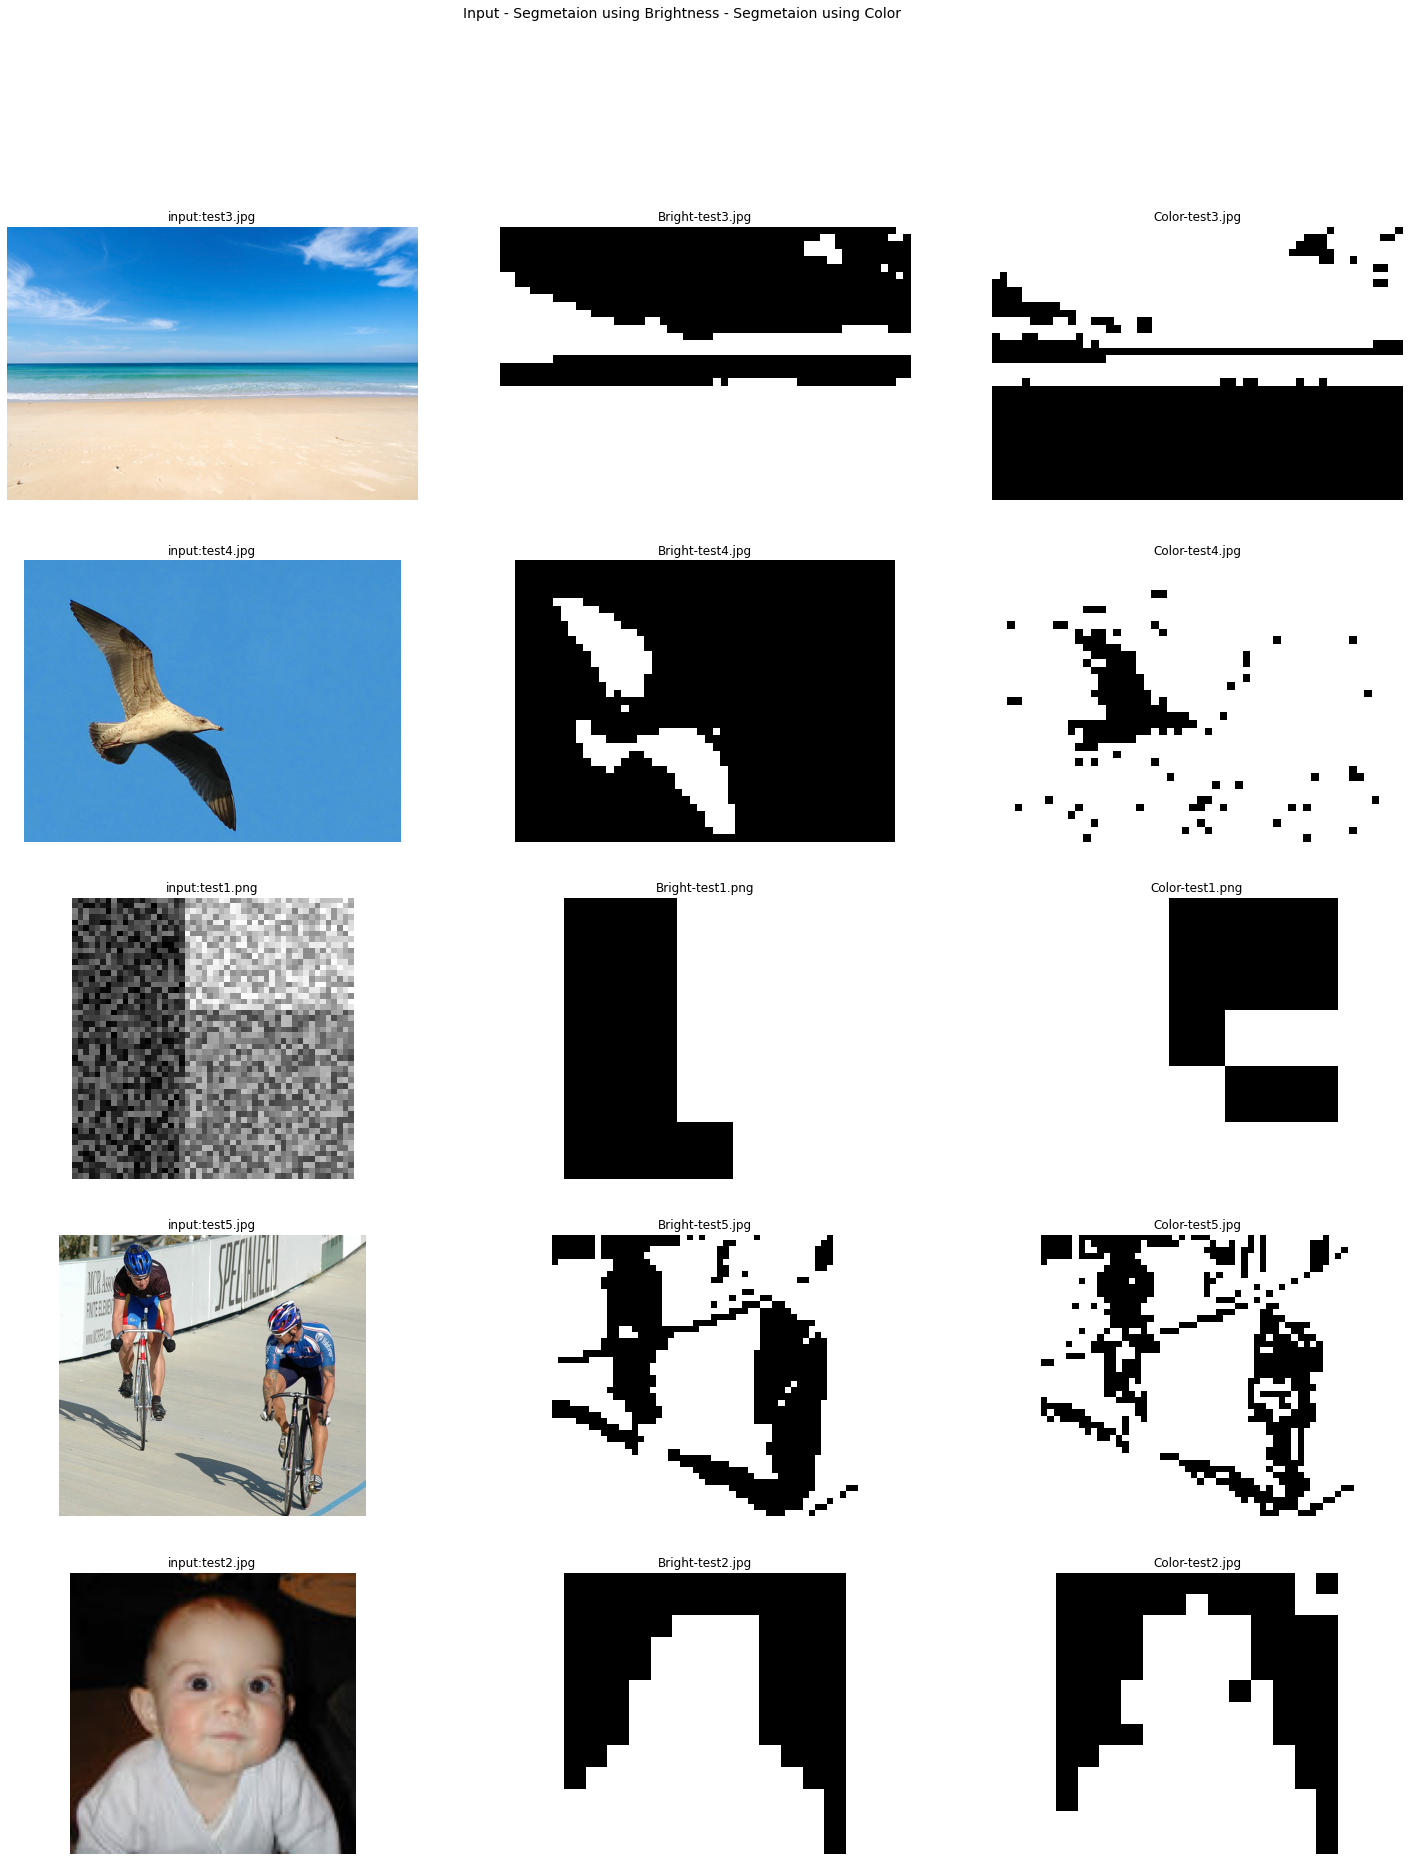

In [630]:
import glob

# Number of rows and cols in output
rows = len(glob.glob("data/test_images/*"))
cols = 3

# Setting up Figure
fig  = plt.figure(figsize=(25,30))
fig.suptitle("Input - Segmetaion using Brightness - Segmetaion using Color", fontsize=14)

# iterating over each image file present in test_images
for i, filename in enumerate(glob.glob("data/test_images/*")):
    # Input
    img = skimage.io.imread(filename)
    name = filename.split("/")[-1]
    # Segmentaion
    B = segmentation_brightness(img, name, 0.1)      
    C = segmentation_color(img, name, 0.1)
    # plotting
    fig.add_subplot(rows, cols, cols*i+1)  
    B.plotter(img, "input:"+ name)
    fig.add_subplot(rows, cols, cols*i+2)
    B.plotter(B.bright,"Bright-"+ name)

    fig.add_subplot(rows, cols, cols*i+3)
    C.plotter(C.color,"Color-"+ name)
plt.autoscale(tight=True)
plt.show()   
